In [19]:
# It allows to import files in the upper directory.
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [20]:
import ai.data_set as ds
from ai.neural_network import create_model, format_data_set, get_inputs_real_outputs
from ai.evaluation import errors

%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

In [21]:
def order_1(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the order 1. In this order, the data set first contains subgrids whose the middle tile does not contain a bomb
    and then contains the subgrids whose the middle tile contains a bomb.
    Data set format: ['num_no_bm_subgrids' * 'no_bm_sg', 'num_bm_subgrids' * 'bm_sg'], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the order 1.
    """
    
    data_set = [next(data_set_no_bm_gen) for i in range(num_no_bm_subgrids)]
    data_set.extend([next(data_set_bm_gen) for i in range(num_bm_subgrids)])
    
    return data_set

def order_2(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the order 2. In this order, the data set first contains the subgrids whose the middle tile contains a bomb
    and then contains subgrids whose the middle tile does not contain a bomb.
    Data set format: ['num_bm_subgrids' * 'bm_sg', 'num_no_bm_subgrids' * 'no_bm_sg'], where 'bm_sg' is a subgrid whose the middle tile contains a bomb
    and 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the order 2.
    """
    
    data_set = [next(data_set_bm_gen) for i in range(num_no_bm_subgrids)]
    data_set.extend([next(data_set_no_bm_gen) for i in range(num_bm_subgrids)])
    
    return data_set

def order_3(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the order 3. In this order, the data set alternates between the subgrids whose the middle tile does not contain a bomb
    and the subgrids whose the middle tile contains a bomb.
    Data set format: ['no_bm_sg', 'bm_sg', 'no_bm_sg', 'bm_sg', 'no_bm_sg', 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the order 3.
    """
    
    data_set = []
    data_set_no_bm = [next(data_set_no_bm_gen) for i in range(num_no_bm_subgrids)]
    data_set_bm = [next(data_set_bm_gen) for i in range(num_bm_subgrids)]
    for data_no_bm, data_bm in zip(data_set_no_bm, data_set_bm):
        data_set.append(data_no_bm)
        data_set.append(data_bm)
    
    return data_set

def order_4(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the order 4. In this order, the ordre of the data set is random.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the order 4.
    """
    
    data_set = [next(data_set_no_bm_gen) for i in range(num_no_bm_subgrids)]
    data_set.extend([next(data_set_bm_gen) for i in range(num_bm_subgrids)])
    
    random.shuffle(data_set)
    
    return data_set

In [25]:
seed = 42

radius_subgrids = 2
num_tiles_subgrids = ((radius_subgrids * 2) + 1) ** 2
num_rows_grid = 10
num_columns_grid = 10
num_bombs_grid = 10
num_no_bm_subgrids = 50000
num_bm_subgrids = 50000
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.
num_masked_subgrids = 10

ds_no_bm_file_name = ds.data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, radius_subgrids, False)
ds_no_bm_file_name = ds_no_bm_file_name[3:]
ds_bm_file_name = ds.data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, radius_subgrids, True)
ds_bm_file_name = ds_bm_file_name[3:]
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.

random.seed(seed)
np.random.seed(int(seed)) # Makes Keras deterministic.
tf.set_random_seed(seed) # Makes TensorFlow deterministic.

# Test set.
data_set_gen = ds.read_data_set(ds_no_bm_file_name)
for i in range(int(ds.SIZE / 2)): next(data_set_gen) # Skip the half of the data set.
test_set = [next(data_set_gen) for i in range(5000)]

data_set_gen = ds.read_data_set(ds_bm_file_name)
for i in range(int(ds.SIZE / 2)): next(data_set_gen) # Skip the half of the data set.
test_set.extend([next(data_set_gen) for i in range(5000)])
print("Data set loaded.")

# Format the test set.
test_set = format_data_set(test_set, num_masked_subgrids)
print("Test set formatted.")

# Get the 'x' and 'y_true' vectors.
x_test, y_true_test = get_inputs_real_outputs(test_set)
print("Inputs and real outputs extracted.\n")

# Data set generators for the training set.
data_set_no_bm_gen = ds.read_data_set(ds_no_bm_file_name)
data_set_bm_gen = ds.read_data_set(ds_bm_file_name)
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.

orders = [order_1, order_2, order_3, order_4]
err_list = []
for i, order in enumerate(orders):
    print("Order {}.".format((i + 1)))
    
    # Load the data set.
    data_set = order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen)
    print("Data set loaded.")
    
     # Format the data set.
    training_set = format_data_set(data_set, num_masked_subgrids)
    print("Data set formatted.")
    
    # Get the 'x' and 'y_true' vectors.
    x_training, y_true_training = get_inputs_real_outputs(training_set)
    print("Inputs and real outputs extracted.")

    # Create the model.
    model = create_model(num_tiles_subgrids)
    
    # Train the model.
    model.fit(x_training, y_true_training, epochs=1, batch_size=10)
    print("Neural network trained.")
    
    # Prediction and errors.
    y_pred = model.predict(x_test)
    y_pred = [y_p[0] for y_p in y_pred]

    # Errors
    error_func = lambda y_t, y_p: abs(y_t - y_p)
    err = errors(y_true_test, y_pred, error_func)
    print("Errors computed.")

    err_list.append(err)
    
    print('')

Data set loaded.
Test set formatted.
Inputs and real outputs extracted.

Order 1.
Data set loaded.
Data set formatted.
Inputs and real outputs extracted.
Epoch 1/1
1000000/1000000 [==============================] - 163s 163us/step - loss: 0.1043 - mean_squared_error: 0.1043 - mean_absolute_error: 0.1918 - acc: 0.8511
Neural network trained.
Errors computed.

Order 2.
Data set loaded.
Data set formatted.
Inputs and real outputs extracted.
Epoch 1/1
1000000/1000000 [==============================] - 139s 139us/step - loss: 0.1049 - mean_squared_error: 0.1049 - mean_absolute_error: 0.1925 - acc: 0.8508
Neural network trained.
Errors computed.

Order 3.
Data set loaded.
Data set formatted.
Inputs and real outputs extracted.
Epoch 1/1
1000000/1000000 [==============================] - 163s 163us/step - loss: 0.1060 - mean_squared_error: 0.1060 - mean_absolute_error: 0.1944 - acc: 0.8492
Neural network trained.
Errors computed.

Order 4.
Data set loaded.
Data set formatted.
Inputs and real o

In [26]:
opacity = 1
color = '#FED487'
edge_color = 'black'
mean_color = 'orange'
percentile_25_color = 'limegreen'
median_color = 'red'
percentile_75_color = 'limegreen'
dot_color = 'black'

save_fig = True
fig_format = 'png'
fig_dpi = 500

<IPython.core.display.Javascript object>


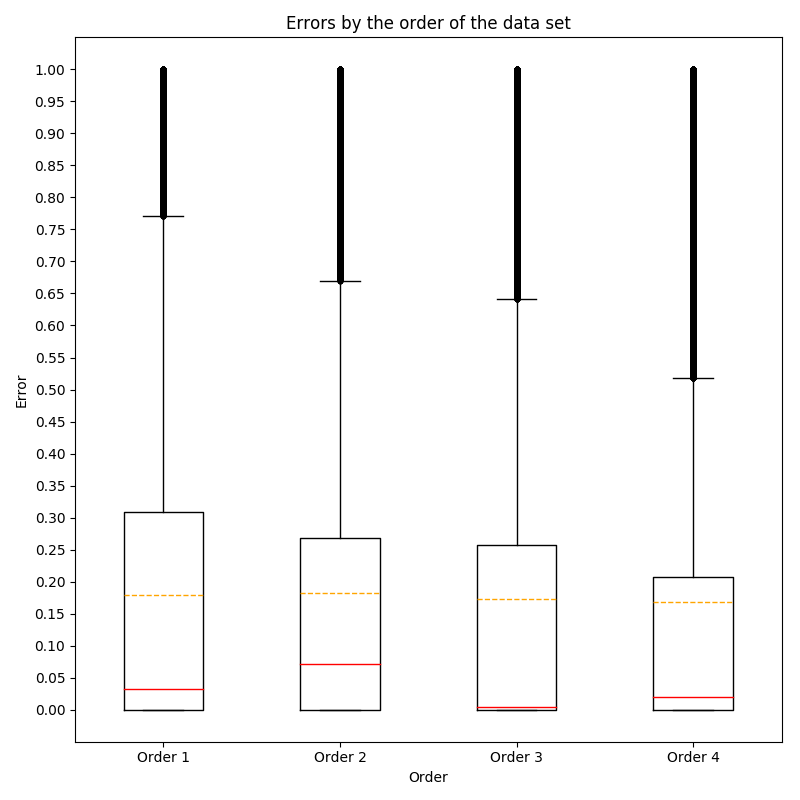

In [27]:
# Box plot of errors by the number of subgrids.

fig = plt.figure(figsize=(8, 8))
bplot = plt.boxplot(err_list, showmeans=True, meanline=True, sym='.')
plt.xticks(range(1, len(orders) + 1), ["Order {}".format((i + 1)) for i in range(len(orders))])
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.title('Errors by the order of the data set')
plt.xlabel('Order')
plt.ylabel('Error')
plt.setp(bplot['means'], color=mean_color)
plt.setp(bplot['medians'], color=median_color)
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig(('errors_by_dataset_order.' + fig_format), format=fig_format, dpi=fig_dpi)